# Byte-Wise Markov Chain Models for Language Detection
This project is a response to the Fellowship.AI Language Detection challenge. The prompt is:


> [European Parliament Proceedings Parallel Corpus](http://www.statmt.org/europarl/) is a text dataset used for evaluating language detection engines. The 1.5GB corpus includes 21 languages spoken in EU.  

> Create a machine learning model trained on this dataset to predict the following [test set](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/language-detection/europarl-test.zip).

## Modeling Byte Sequences
I spent some time learning about UTF-8 encoding (the encoding used in the Europarl corpus). Unlike ASCII, UTF-8 uses a variable number of bytes per character. It is reverse-compatible with ASCII, and reserves the ASCII bytes for a one-byte-per-character scheme. To expand its vocabulary to encompass all of Unicode, UTF-8 uses certain bytes (with decimal values above 128) to signal a coming byte chain that will encode a single unicode character.<br><br>
As many of the languages in this corpus use unique characters, a model than can look at the sequences of bytes that appear in a given language will be powerful.

## Markov Chains
A Markov Chain model assumes that the probability of the next link of the series (in our case, the next byte) depends only on the previous links (the previous bytes.) The number of bytes in the model's "memory" is known as the "order" of the model.<br><br>
This is a first-order Markov Chain model of the sentence, "One fish two fish red fish blue fish."

![First-Order Markov Chain](https://cdn-images-1.medium.com/max/1600/1*UuD1-B7CFn3M2nUDy02sHg.png)

(Thanks to [Alexander Dejeu and Hackernoon for the image](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71).)<br>
Notice the first-order model gives equal probability to the next state being "two", "red", "blue", or \*END\* when the current state is "fish."<br><br>
To improve the model, we can increase the order of the model to remember the state or states before the word "fish", giving us a way to model the order of the words "two", "red", and "blue." Instead of words, my Markov chains use unique byte values to model the probability distribution of the next byte's value in a sequence.<br><br>
The model expands on a Naive Bayes model by using the conditional probability of a byte, the condition being the previous byte or sequence of bytes:  
* **no memory** (naive bayes): 
$$P(sequence) = P(b_1)P(b_2)P(b_3)...P(b_n) = \prod_{t=1}^{n}P(b_t)$$ 
* **With the Markov Property, we can write (1st order Markov)**: 
$$P(sequence) = P(b_1)P(b_2|b_1)P(b_3|b_2)...P(b_n|b_{n-1}) = P(b_1)\prod_{t=2}^{n}P(b_t|b_{t-1})$$ 
* **2nd Order (remembers two previous bytes)**: 
$$P(sequence) = P(b_1)P(b_2|b_1)\prod_{t=3}^{n}P(b_t|b_{t-1},b_{t-2})$$ 

Where $P(sequence)$ is the probability of a sequence of bytes $b_1$ to $b_n$.

## Markov Chains for Classification
Markov Chain models are usually used to predict the next character or word in a series. A famous example is the "next word recommendation" feature when writing a text message. These simple models work surprisingly well in this application, helping some users compose texts more quickly. In fact, the models I train for this task can also be used to generate output. Take a look at my exploration of generated output in [this notebook](https://github.com/AlliedToasters/language_detector/blob/master/markov_speak.ipynb).<br><br>
However, in this case, we are looking to classify chains of bytes as coming from a certain language. To do this, we just need to multiply the probabilities of a set of pre-trained models moving along the byte sequence of the text in question. Formally,

$$P(Language | Sequence) = \frac{P(Sequence | Language)P(Language)}{P(Sequence)}$$  

$P(Language)$ is just the prior probability of a language. For our purposes, this is 1.
$P(Sequence)$ is also 1. Thus,

for first order Markov:
$$  \mathbf{predicted\:language} = argmax\:\{ \prod_{t=2}^{n}P(b_t|b_{t-1},Language)P(Language)\}   $$
2nd order:
$$  \mathbf{predicted\:language} = argmax\:\{ \prod_{t=3}^{n}P(b_t|b_{t-1},a_{t-2},Language)P(Language)\}   $$

and so on. This is the theory, but in practice there a few problems. If a byte sequence was never seen at training time by the model, but is encountered at prediction time, it will assign a probability of zero to that class. If we are multiplying probabilities, any zero will bring the entire class probability to zero. This is undesireable, as we may simply have encountered an anomaly (such as a different language in quotations or a name). Also, the set of all $P(b_t|b_{t-1},Language)$ across all language classes should sum to one if we assume the sequence in question certainly belongs to one of the classes. To address this issue, I use the softmax function on the vector of likelihoods across all classes for a given byte sequence; this brings zero values to nonzero values and forces the sum of likelihoods to one at each step.<br><br>

### Prediction Time and Early Stopping
To save time at prediction time, I use a convergence condition for early stopping. When the likelihood for a given class reaches .9, the model will return its prediction without completing the byte sequence. This threshold of .9 is adjustable, and in my final model I disable early stopping by setting this value to 1.

## Preparing the Data
I will train with the Europarl corpus and validate with the set provided by Fellowship AI. To run this script, make sure you have the following dependencies installed. The following cell should get things set up for you on a Ubuntu system. It will download all of the europarl corpus and validation set to your hard drive! You should of course use a fresh virtualenv or conda environment. This script uses Python 3.6 syntax.

In [ ]:
#Hide training data in git-ignored ./data directory because it's too big for GitHub.
!mkdir data
!wget -P ./data http://www.statmt.org/europarl/v7/europarl.tgz
!tar -xzf ./data/europarl.tgz -C ./data/
#Download and unzip validation data
!wget https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/language-detection/europarl-test.zip
!unzip europarl-test.zip
#Install dependencies
!pip install scipy
!pip install numpy
!pip install pandas
!pip install sparse
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [1]:
import os
import re
import sys
import pickle
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from markov_model import MarkovChainModel
from presentation import one_hot_encode, compute_results, plot_results, plot_confusion

In [2]:
#Create a dataframe to manage files and labels.
cols = ['lang', 'path']
df = pd.DataFrame(columns=cols)

languages = os.popen('ls ./data/txt/').read().split('\n')[:-1]
for lang in languages:
    print('adding language {}...'.format(lang))
    lang_frame = pd.DataFrame(columns=cols)
    txts = os.popen('ls ./data/txt/{}/'.format(lang)).read().split('\n')[:-1]
    paths = ['./data/txt/{}/{}'.format(lang, txt) for txt in txts]
    lang_frame['path'] = paths
    lang_frame['lang'] = lang
    lang_frame.index = range(len(df), len(df)+len(lang_frame))
    df = pd.concat([df, lang_frame], axis=0)

adding language bg...
adding language cs...
adding language da...
adding language de...
adding language el...
adding language en...
adding language es...
adding language et...
adding language fi...
adding language fr...
adding language hu...
adding language it...
adding language lt...
adding language lv...
adding language nl...
adding language pl...
adding language pt...
adding language ro...
adding language sk...
adding language sl...
adding language sv...


## Labelled Text
To simplify training, I combine all of the texts for each language into a single .txt file located at ./data/{language}.txt. I remove some html tag-looking artifacts from the dataset. <br>
For anybody interested in training up a Markov chain model on this dataset, uncomment the last line of the following cell.

In [3]:
def get_text(idx, df):
    """Takes idx and df and returns text."""
    path = df.loc[idx].path
    with open(path, 'r') as f:
        result = f.read()
    return result

def remove_tags(input_string):
    """Removes html tag-like artifacts in the data."""
    result = input_string
    tag = re.compile(r'<[^<]*>')
    while tag.search(result):
        match = tag.search(result)
        strt = match.span()[0]
        stp = match.span()[1]
        result = result[:strt] + result[stp:]
    return result

def prepare_data(df):
    """Takes dataframe and gathers text from each language label,
    concatenating them into one .txt file for each language."""
    for lang in df.lang.unique():
        cnt = 0
        full_text = ''
        lng_df = df[df.lang == lang]
        print('gathering data: ', lang)
        for i, row in lng_df.iterrows():
            try:
                txt = get_text(i, lng_df)
            except UnicodeDecodeError:
                print('problem decoding: ', i, lang)
                continue
            txt = remove_tags(txt)
            full_text += txt
            cnt += 1
        with open('./data/{}.txt'.format(lang), 'w+', encoding='utf-8') as f:
            f.write(full_text)
            
#Uncomment this line if you plan on training new models:
#prepare_data(df)

### Decode Error
There is one decoding error in the language "pl." Since this problem occurs just once, I omit the text from that file from the training data.

## Markov Chain Software
It was surprisingly hard to find software to apply this model. I ended up coding it up from scratch using [a new python package for high-dimensional sparse matrices](http://sparse.pydata.org/en/latest/) (thanks to [mrocklin](https://github.com/mrocklin) for putting it together!) I was able to scrape it together in just over 200 lines of code between two scripts, one [for training](https://github.com/AlliedToasters/language_detector/blob/master/train_markov_chain.py) and the other [for predictions](https://github.com/AlliedToasters/language_detector/blob/master/markov_model.py).

## Performance Benchmark
To give some context for my model performance, I tried out Google's language detection library. The results are detailed in [this notebook](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb); their model gives an accuracy of 99.7% to 99.8% on the same validation set used in this notebook. Interestingly, Google's model is non-deterministic, meaning it gives different results on each run. However, the results always tend to fall into a similar error rate.

## First Model: First-Order Markov Chain
For starters, I train up a first-order Markov chain model. Remember, "first-order" means the model assumes the next byte depends only on the previous byte. Another way to think of it is the model has a "memory" of one byte. This model can be stored in a 21x184x184 sparse matrix. (There are 256 unique-valued bytes, but only 183 appear in the dataset. I include an extra for any "other" bytes, to keep my model robust to surprises.) This model uses 634 kB of disk space to store.<br><br>
<b>Note that, due to UTF-8's encoding scheme, this model is very similar to a Naive Baye's classifier based on character unigrams and bigram counts.</b><br><br>
I train this model with 10,000,000 bytes from each language, which takes about 20 minutes per language or 7 hours altogether on my machine.

In [4]:
def get_model(
        languages, 
        order=1, 
        save_path='./models/{}_o{}.pkl', 
        data_path='./data/{}.txt', 
        num_bytes=10000000,
        prediction_cutoff=.9
    ):
    """Loads the specified model. If files not found, trains model.
    To train a new model, pass a new format for the save_path argument. Make sure
    you've run the prepare_data() or specify a new path in data_path for training data.
    num_bytes specifies the number of bytes to train on; prediction cutoff controls
    the early stopping condition at prediction time."""
    try:
        model = MarkovChainModel(languages, prediction_cutoff=prediction_cutoff, order=order, base_path=save_path)
    except FileNotFoundError:
        print('model files not found. Training...')
        for lang in languages:
            t1 = time()
            save = save_path.format(lang, str(order))
            data = data_path.format(lang)
            command = 'python train_markov_chain.py -save_model {} -data {} -order {} -num_bytes {}'.format(
                save,
                data,
                order,
                num_bytes
            )
            print(os.popen(command).read())
            print('took {} seconds.\n'.format(time() - t1))
        model = MarkovChainModel(languages, prediction_cutoff=prediction_cutoff, order=order, base_path=save_path)
    return model

In [5]:
#load validation set
test_set = pd.read_csv('europarl.test', sep='\t', header=None)
test_set.columns = ['lang', 'text']

#one-hot-encode languages for log-loss computation
lb = LabelBinarizer()
Y = lb.fit_transform(test_set.lang)

def get_predictions(order, languages=languages, test_set=test_set, prediction_cutoff=.9):
    """Loads model and gets predictions on test set."""
    model = get_model(languages, order=order, prediction_cutoff=.9)
    predictions = []
    for i, row in test_set.iterrows():
        predictions.append(model.predict(row.text.encode(encoding='utf-8')))
    pred = np.array(predictions)
    return pred, model

loading models...
Done!


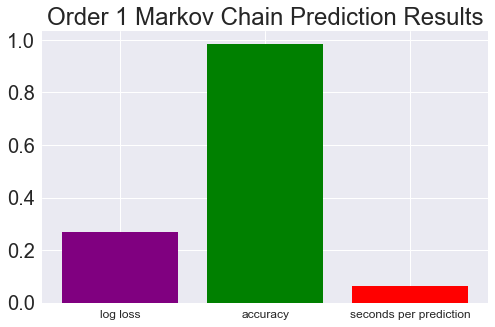

Accuracy: 98.49%


In [6]:
#Run the model on test set.
t_start = time()
pred1, model1 = get_predictions(order=1)
order1_prediction_time = time() - t_start
order1_spp = order1_prediction_time / len(test_set)
loss1, accuracy1 = compute_results(Y, pred1)
plot_results(loss1, accuracy1, order1_spp, 'Order 1 Markov Chain Prediction Results')
print('Accuracy: {}%'.format(round(100 * accuracy1, 2)))

## Discussion
The first order model does remarkably well considering its limitations. With UTF-8, some unicode characters can take up to four bytes to encode. The effective scope of the first-order Markov chain is any two-byte combination. In essence, this model is unable to recognize characters encoded with more than two bytes. However, it still achieves close to 98.5% accuracy by modeling which bytes pairs tend to appear in different languages. It is probably able to do this because certain specific two-byte sequences will only appear, or appear with much different frequencies, in certain languages that require access to higher byte-per-character unicode characters in the UTF-8 scheme.<br>
This model is bested by the [benchmark performance of Google's language detection library on the same validation data](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb).

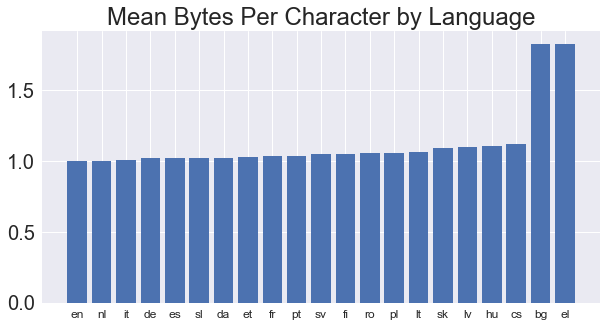

In [7]:
bytes_per_char = dict()
for lang in test_set.lang.unique():
    examples = test_set[test_set.lang==lang].text
    char_length = 0
    encode_length = 0
    for txt in examples:
        char_length += len(txt)
        encode_length += len(txt.encode(encoding='utf-8'))
    bpc = encode_length/char_length
    bytes_per_char[lang] = bpc

items = list(bytes_per_char.items())
reverse_dict = {y[1]:y[0] for y in items}
ordered = [y[1] for y in items]
ordered.sort()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Mean Bytes Per Character by Language')
ax.bar([i for i in range(len(bytes_per_char))], ordered)
ax.tick_params('x', labelsize=12)
ax.set_xticks([i for i in range(len(bytes_per_char))])
ax.set_xticklabels([reverse_dict[y] for y in ordered])
plt.show();

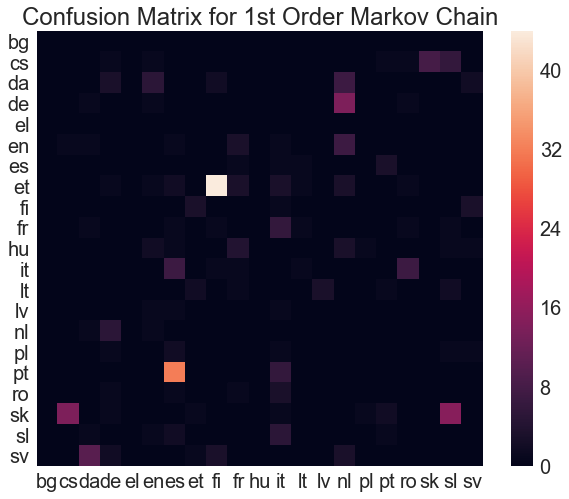

In [8]:
mat = plot_confusion(Y, pred1, model1, 'Confusion Matrix for 1st Order Markov Chain')
#mat

In the above confusion matrix, the diagonal (correct) values have been set to zero to make the remaining information more visible. The x axis denotes predicted languages and the y axis denotes ground truth languages. We see two major confusions: samples classified as Spanish (es) that are Portuguese (pt) and samples classified as Finnish (ft) that are Estonian (et). These confusions make sense, since a lot of similar characters appear in these language pairs. ([Estonian-Finnish](https://www.quora.com/How-different-are-the-Finnish-and-Estonian-languages); [Spanish-Portugues](https://www.reginacoeli.com/blog/the-differences-between-spanish-and-portuguese.html))<br><br>
Interestingly, the languages with very high bytes-per-character ratios (bg and el) are classified with high precision and recall. This is likely because of the unique byte pairs they contain that are rare or unseen in other languages.

## Second Model: 3rd Order Markov Chain
To address the weaknesses of the first model, I deploy a 3rd order model. This model "remembers" three previous bytes when computing the probability distribution of the next byte. This enables the model to recognize entire character sequences even for 4-bytes-per-character encodings; it is also able to start modelling spelling patterns by linking together multiple characters.<br><br>
This model can be stored as a 21x184x184x184x184 sparse matrix; notice that each order adds an additional dimension of size 184 to the model. This is 20.3 MB of data. I trained it on 10,000,000 bytes per language.

loading models...
Done!


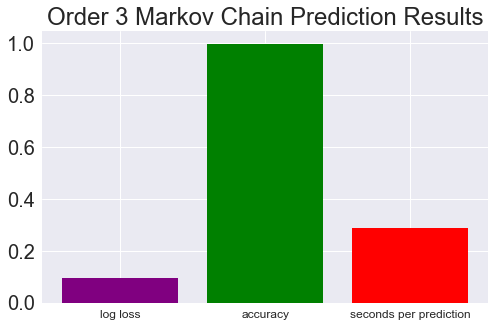

Accuracy: 99.75%


In [9]:
t_start = time()
pred3, model3 = get_predictions(order=3)
order3_prediction_time = time() - t_start
order3_spp = order3_prediction_time / len(test_set)
loss3, accuracy3 = compute_results(Y, pred3)
plot_results(loss3, accuracy3, order3_spp, 'Order 3 Markov Chain Prediction Results')
print('Accuracy: {}%'.format(round(100 * accuracy3, 2)))

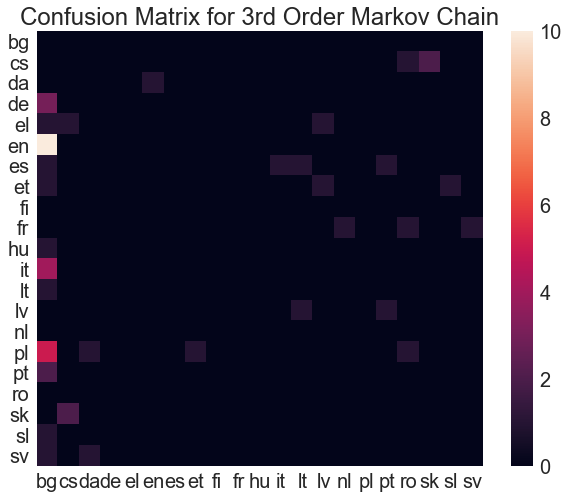

In [10]:
mat = plot_confusion(Y, pred3, model3, 'Confusion Matrix for 3rd Order Markov Chain')

## Discussion
The third order model does much better, giving an accuracy of 99.7% on the validation set. Interestingly, its confusions are almost all confusions with Bulgarian (bg); that is, the model tends to mistakingly assign Bulgarian to other languages, most frequently English (en).<br><br> 
After exploring the generative output of these models, it looks like there may be some impurities in the Bulgarian-labelled text that causes that model to have relatively poor recall. Take a look at that exploration [here](https://github.com/AlliedToasters/language_detector/blob/master/markov_speak.ipynb).<br>
In any case, the model performs very well; the only drawback is it's relatively slow to make predictions, clocking in just over four predictions per second.<br><br>
This model effectively ties the [benchmark performance of Google's language detection library on the same validation data](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb), but takes consirably longer to perform predictions than the benchmark model.

## Third Model: 5th Order Markov Chain
In theory, a higher order Markov Chain model is more powerful; in practice, a larger sample size is needed to train an effective model. We have a very large corpus, so this shouldn't be a problem. However, training time is a problem. The fifth order model takes about an hour per language to train using the 10,000,000 bytes for each class. I decided not to increase the sample size to keep the training period under one day, but we could in theory improve performance further with more training data and patience.<br><br>
This model is represented by a 21x184x184x184x184x184x184 sparse matrix and takes up 144.2 MB of disk space to store.

loading models...
Done!


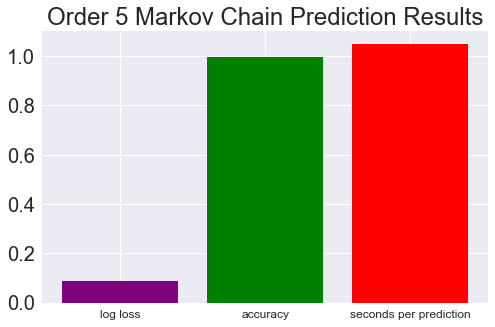

Accuracy: 99.79%


In [11]:
t_start = time()
pred5, model5 = get_predictions(order=5, prediction_cutoff=1)
order5_prediction_time = time() - t_start
order5_spp = order5_prediction_time / len(test_set)
loss5, accuracy5 = compute_results(Y, pred5)
plot_results(loss5, accuracy5, order5_spp, 'Order 5 Markov Chain Prediction Results')
print('Accuracy: {}%'.format(round(100 * accuracy5, 2)))

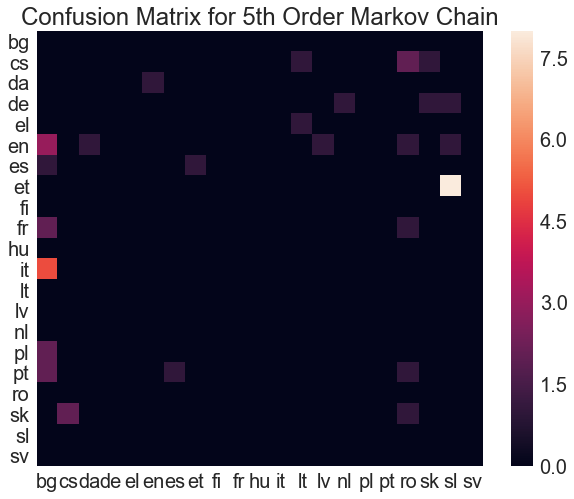

In [12]:
mat = plot_confusion(Y, pred5, model5, 'Confusion Matrix for 5th Order Markov Chain')

### Discussion
We see that this model indeed outperforms the previous models; it does so at the cost of taking a very long time to perform predictions. At over one second per prediction, using this model may not be practical. Since I wrote the code to deploy these models, there are probably inefficiencies and things we can do to speed up the prediction time.<br><br>
One reason why this model takes so much longer to predict than the others is that I disabled the "early stop" condition. In the previous models, when a certain language class reaches a likelihood of .9, the model returns the prediction early. This is done to speed up the prediction time. With this model, I effectively disable early stopping by setting the cutoff to 1 (likelihoods will never reach 1.) I did this to get the best predictions possible from this model.<br><br>
This model is able to outperform the [benchmark performance of Google's language detection library on the same validation data](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb), but at the cost of feasibility. Deploying this model may not be practical because of the high computation time.

## Ensemble Model
To increase accuracy, we can combine the models. A simple way to build such an "ensemble model" is to average the likelihoods from each of the models for each prediction. We simply add computation times together to get the ensemble computation time.

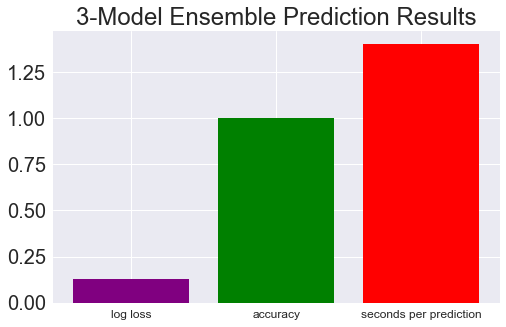

Accuracy: 99.91%


In [13]:
ensemble = (pred1 + pred3 + pred5)/3
spp_ensemble = order1_spp + order3_spp + order5_spp
loss, accuracy = compute_results(Y, ensemble)
plot_results(loss, accuracy, spp_ensemble, '3-Model Ensemble Prediction Results')
print('Accuracy: {}%'.format(round(100 * accuracy, 2)))

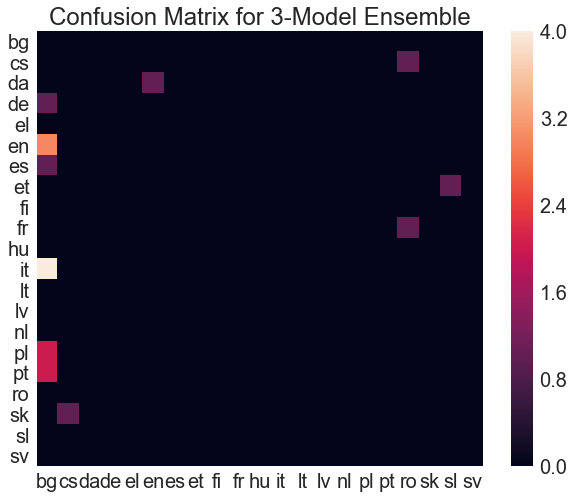

In [14]:
mat = plot_confusion(Y, ensemble, model1, 'Confusion Matrix for 3-Model Ensemble')

In [15]:
# Save results for benchmark ensemble
np.save('pred1.npy', pred1)
np.save('pred3.npy', pred3)
np.save('pred5.npy', pred5)

### Discussion
The ensemble model is able to improve on the results of all three individual models. Importantly, both the 5th order Markov Chain model and the ensemble model are able to beat the [benchmark performance as generated by Google's language detection library.](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb).<br><br>
The best results I've been able to achieve come from ensembling these three models with the benchmark model itself; the result is an accuray level of 99.93%. See the last few cells of the [benchmark notebook](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb) for those results.

## Conclusion
This notebook has shown the power of sequence modeling, and Markov Chains turn out to be a straightforward and robust way to model the sequences of bytes that appear in these languages. Importantly, I was able to significantly outperform the [benchmark performance](https://github.com/AlliedToasters/language_detector/blob/master/benchmark.ipynb) and reach an error rate smaller than one in a thousand.<br>
The biggest drawback to my models is the computation time. Considering the fact that I hand-coded the models, it's very likely that the algorithm can benefit from some serious optimization. This notebook should serve simply as a proof of concept; deploying the model would require some engineering.
### Related Applications
By taking advantage of byte-level features, similar models could potentially be applied to other tricky problems such as encoding detection or language detection with a higher number of classes. 